To create the autoencoder, we use the Python language and the Torch framework. Let us start by importing the required libraries and the MNIST dataset we want to compress.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 91005965.35it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46752487.00it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21510322.68it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1070013.97it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [2]:
# Create training and test dataloaders
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Once the loading of data is completed, the loader functions for training and testing our model have been created for visualization.

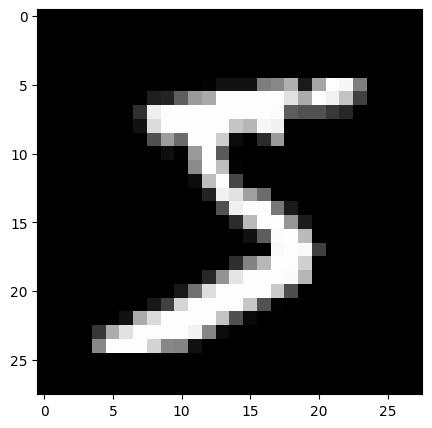

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# obtain one batch of training images
dataiter = iter(train_loader)
#images, labels = dataiter.next()
images, labels = next(dataiter)
images = images.numpy()
# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

The linear autoencoder comprises only flattening layers. Activation functions like ReLU are at the input end, and Sigmoid is at the output end.

During training, we create an autoencoder class, that comprises two flattening layers, fc1 and fc2. fc1 is an encoder and compresses the input image to a (784, 32) dimension vector, and the second layer, fc2, works as a decoder and decompresses the image to the required output (32, 784) dimension.

In [5]:
import torch.nn as nn
import torch.nn.functional as F
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x
# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


Now, we need to decide the optimizer and loss function to train the entire model.

In [6]:
# specify loss function
criterion = nn.MSELoss()
# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In this linear autoencoder, MSE (Mean Squared Error Loss) and the Adam optimizer is used.

The entire training process works in the following way:

1. After passing the input image to the model, we generate the output with the help of the sigmoid activation function.

2. A loss calculation is done for the actual and predicted values.

3. Backpropagation and adjustment are done for the parameters to minimize the loss.

In [7]:
# number of epochs to train the model
n_epochs = 20
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
    # print avg training statistics
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss ))

Epoch: 1 tTraining Loss: 0.741553
Epoch: 2 tTraining Loss: 0.404761
Epoch: 3 tTraining Loss: 0.368203
Epoch: 4 tTraining Loss: 0.360122
Epoch: 5 tTraining Loss: 0.356951
Epoch: 6 tTraining Loss: 0.354789
Epoch: 7 tTraining Loss: 0.353070
Epoch: 8 tTraining Loss: 0.351661
Epoch: 9 tTraining Loss: 0.350417
Epoch: 10 tTraining Loss: 0.349337
Epoch: 11 tTraining Loss: 0.348391
Epoch: 12 tTraining Loss: 0.347543
Epoch: 13 tTraining Loss: 0.346775
Epoch: 14 tTraining Loss: 0.346075
Epoch: 15 tTraining Loss: 0.345432
Epoch: 16 tTraining Loss: 0.344758
Epoch: 17 tTraining Loss: 0.344211
Epoch: 18 tTraining Loss: 0.343722
Epoch: 19 tTraining Loss: 0.343243
Epoch: 20 tTraining Loss: 0.342832


As the training is done, let us apply it to one batch of test images.

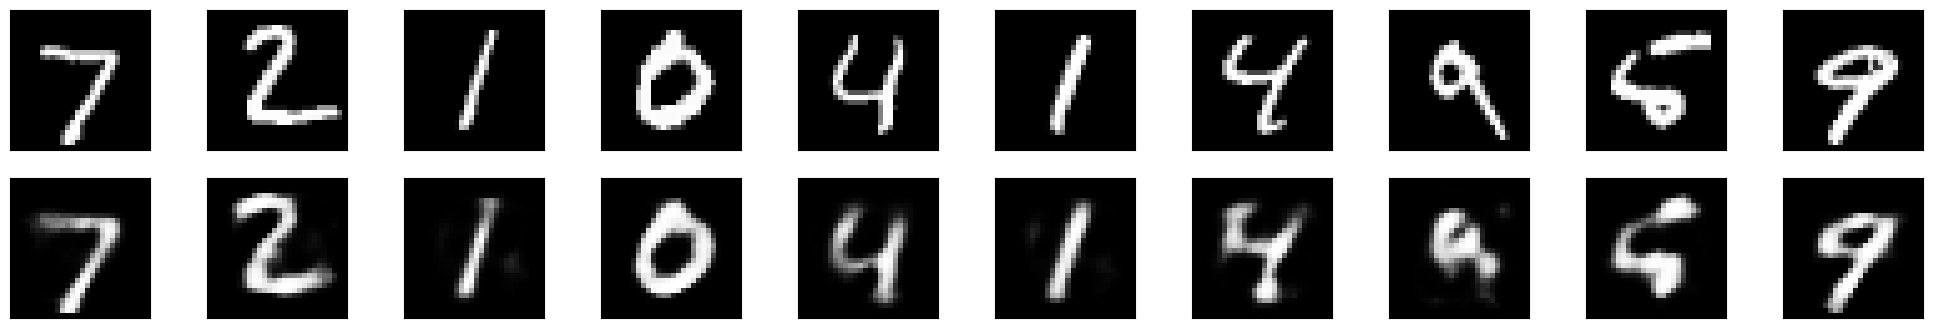

In [9]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()
# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In this way, we can create the image compressor using autoencoders applicable to any image dataset. However, instead of linear layers, we can also experiment with the LSTM and CNN layers.